### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 5: CNN

Dans ce laboratoire, nous allons implémenter avec l'aide de PyTorch divers réseaux à convolutions. La [documentation de PyTorch](https://pytorch.org/docs/stable/index.html) va donc vous être d'un grand secours. Entre autres, la documentation de [`torch`](https://pytorch.org/docs/stable/torch.html), [`torch.nn`](https://pytorch.org/docs/stable/nn.html) (que nous avons importé sous le nom de `nn`) ainsi que [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) (que nous avons importé sous le nom de `F`). En particulier, voici une liste de classes ou de fonctions dont vous êtes susceptible d'utiliser au cours de ce laboratoire.
- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
- [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
- [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList)

In [1]:
from deeplib.training import train, test
import torch.optim as optim
import torch
import numpy as np
from deeplib.datasets import load_cifar10, load_mnist
from deeplib.visualization import view_filters
import torch.nn.functional as F
import torch.nn as nn
from random import randrange

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

Files already downloaded and verified
Files already downloaded and verified


## Filtres de convolution

Lors de l'entraînement, le réseau apprend les bons paramètres à utiliser. Par contre, autrefois, il fallait utiliser des filtres fait à la main comme [les filtres de Gabor](https://en.wikipedia.org/wiki/Gabor_filter).

### Exercice

Le réseau suivant contient une seule couche à convolution. 

Créez manuellement quelques fitres que vous utiliserez pour faire de la classification sur CIFAR10. 

Par la suite, figez les poids de la couche de convolution et entraînez le réseau. 
Tentez d'obtenir les meilleurs résultat possible.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.fc = nn.Linear(6 * 14 * 14, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

Modifier les paramètres des filtres. Essayez de faire des filtres permettant d'extraire des caractéristiques de bas niveau (ligne, coin, etc...). Vous pouvez consulter [ceci](http://lodev.org/cgtutor/filtering.html) pour avoir des idées.

In [3]:
filters = []
filters.append([[[0, 0, 0],
                 [0, 1, 0],
                 [0, 0, 0]]]) # Ce filtre retourne l'image original

"""
filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])
"""

# Arete verticales
filters.append([[[-1, 0, 1],
                 [-1, 0, 1],
                 [-1, 0, 1]]])

# Aretes horizontales
filters.append([[[-1, -1, -1],
                 [0, 0, 0],
                 [1, 1, 1]]])

# Motion blur (gaussien)
filters.append([[[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]])

# Arete toute directions
filters.append([[[-1, -1, -1],
                 [-1, 8, -1],
                 [-1, -1, -1]]])

# Emboss (shadow effect of image)
filters.append([[[-1, -1, 0],
                 [-1, 0, 1],
                 [0, 1, 1]]])


In [4]:
# On crée le réseau, remplace les paramètres par les filtres précédents et fige les poids.

net = Net()
filters = np.asarray(filters, dtype=np.float32)
net.conv1.weight.data = torch.from_numpy(filters)
for param in net.conv1.parameters():
    param.requires_grad = False # Ceci fige chacune des couches
net = net.cuda()

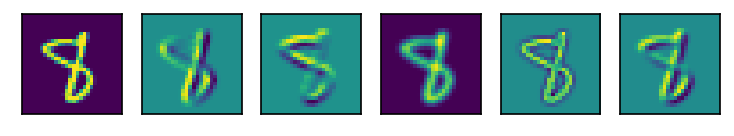

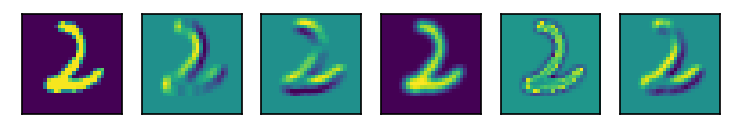

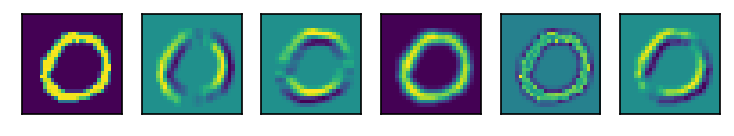

In [5]:
# Vous pouvez utiliser cette cellule pour visualiser l'effet de vos filtres sur des images du dataset.
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

In [6]:
lr = 0.001
n_epoch = 5
batch_size = 32

Epoch: 1/5 Step: 1500/1500 100.00% |████████████████████|7.09s loss: 0.270738 acc: 91.939583 val_loss: 0.178585 val_acc: 94.700000
Epoch: 2/5 Step: 1500/1500 100.00% |████████████████████|7.01s loss: 0.152425 acc: 95.560417 val_loss: 0.147746 val_acc: 95.516667
Epoch: 3/5 Step: 1500/1500 100.00% |████████████████████|7.10s loss: 0.126988 acc: 96.179167 val_loss: 0.139643 val_acc: 95.825000
Epoch: 4/5 Step: 1500/1500 100.00% |████████████████████|7.03s loss: 0.114143 acc: 96.537500 val_loss: 0.113112 val_acc: 96.491667
Epoch: 5/5 Step: 1500/1500 100.00% |████████████████████|7.07s loss: 0.103485 acc: 96.839583 val_loss: 0.130513 val_acc: 96.100000


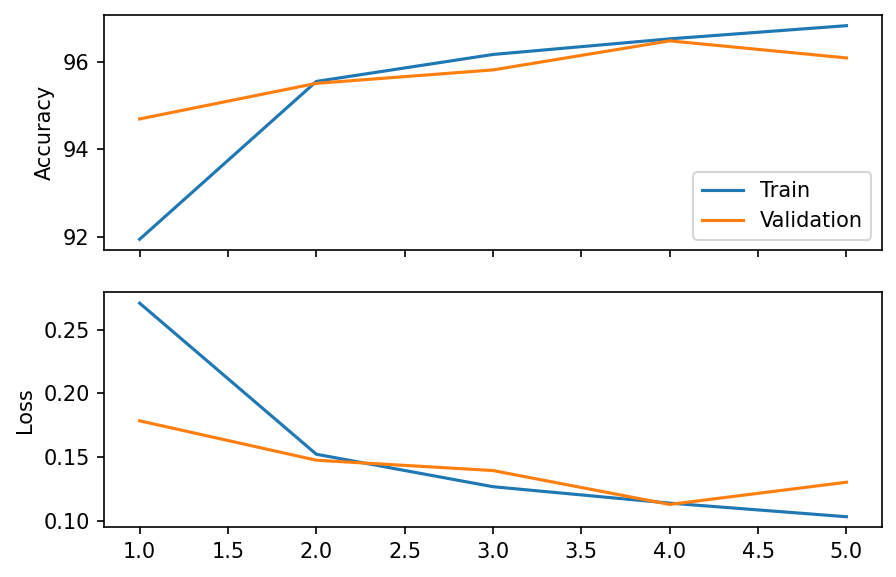

Précision en test: 96.08


In [7]:
optimizer = optim.Adam(net.fc.parameters(), lr=lr) # On optimise uniquement la couche pleinement connectée.
history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

## Utilisation des filtres à convolutions

Comme on peut le constater dans l'interface de la classe [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) de PyTorch, les couches à convolutions ont des hyperparamètres ayant tous divers effets. Dans cette section, nous explorerons les plus importants.

Voici donc l'interface simplifiée de la classe:

`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`

Lorsqu'on utilise la classe, elle s'attend à recevoir en entrée un tenseur de taille `(taille de la batch, channels, hauteur, largeur)`. Par exemple dans le cas de CIFAR10, on aurait en tenseur de taille `(taille de la batch, 3, 32, 32)`. Créons nous un tenseur de taille similaire.

In [8]:
image_batch = torch.randn(8, 3, 32, 32)

Notez que le premier paramètre `in_channels` de `nn.Conv2d` doit correspondre au nombre de channels du tenseur donné en entrée de la couche. Par exemple, la couche à convolution de 100 filtres 3x3 que l'on crée dans le code suivant va nous donner une erreur étant donné qu'on spécifie 2 channels au lieu de 3.

In [9]:
conv = nn.Conv2d(2, 100, 3)
conv(image_batch)

RuntimeError: Given groups=1, weight of size [100, 2, 3, 3], expected input[8, 3, 32, 32] to have 2 channels, but got 3 channels instead

Créons maintenant une couche à convolution de 100 filtres 3x3 avec le bon nombre de channels en entrée et regardons la shape du tenseur résultant.

In [10]:
conv = nn.Conv2d(3, 100, 3)
conv(image_batch).shape

torch.Size([8, 100, 30, 30])

On remarque que la taille du tenseur de sortie a 100 channels étant donné qu'on a demandé 100 filtres à convolution. On remarque aussi que la hauteur et la largeur ont diminué de 2 dû à la convolution. Pour palier à ceci, ajoutons un padding de 1.

In [11]:
conv = nn.Conv2d(3, 100, 3, padding=1)
conv(image_batch).shape

torch.Size([8, 100, 32, 32])

Quand vient le temps d'empiler les couches à convolution, il faut tenir compte du nombre de channels en sortie de la couche précédente pour la couche suivante. Corrigez le code ci-dessous pour que l'appel des couches à convolution s'effectue sans erreur.

In [12]:
"""
# TODO Corrigez le code suivant
conv1 = nn.Conv2d(3, 100, 3, padding=1)
conv2 = nn.Conv2d(3, 100, 3, padding=1)
conv2(conv1(image_batch)).shape
"""

conv1 = nn.Conv2d(3, 100, 3, padding=1)
conv2 = nn.Conv2d(100, 100, 3, padding=1)
conv2(conv1(image_batch)).shape

torch.Size([8, 100, 32, 32])

Testons maintenant avec des filtres de tailles différentes. On remarquera que la hauteur et la largeur ont changé avec des filtres plus gros. Ajustez le padding pour que la hauteur et la largeur reste la même.

In [13]:
"""
conv = nn.Conv2d(3, 100, 5, padding=1)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=1)
print("Filtre 7x7:", conv(image_batch).shape)
"""

conv = nn.Conv2d(3, 100, 5, padding=2)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=3)
print("Filtre 7x7:", conv(image_batch).shape)

Filtre 5x5: torch.Size([8, 100, 32, 32])
Filtre 7x7: torch.Size([8, 100, 32, 32])


Mettons maintenant un *stride* de 2. Ceci va faire en sorte que les filtres à convolutions auront des déplacements de taille 2 au lieu de 1.

In [14]:
conv = nn.Conv2d(3, 100, 3, padding=1, stride=2)
conv(image_batch).shape

torch.Size([8, 100, 16, 16])

On remarque que la hauteur et la largeur du tenseur résultant ont été divisés par 2.

## Architecture de base

### Exercice

Implémentez une architecture de base de réseau de neurones à convolution pour CIFAR10 ayant les caractéristiques suivantes.

1. 3 couches à convolution (voir [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)).
2. Toutes les couches ont 100 filtres de taille 3x3 et 1 de padding.
3. Batch normalization après chaque couche (voir [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)).
4. Utiliser la ReLU comme fonction d'activation (Voir [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).
5. Maxpooling avec un noyau de taille 2 après les 2 premières couches. (Voir [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)).
6. 1 seule couche linéaire pour la classification (aucune activation nécessaire) (Voir [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)).

Ne pas oublier d'utiliser [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) avant la couche de classification sinon vous allez obtenir des erreurs de *shape*.

Essentiellement, chaque couche devrait consister en `Conv2d -> BatchNorm2d -> ReLU` suivi de `MaxPool2d` pour les deux premières couches. Notez que le maxpooling et la ReLU pourraient être échangé étant donné que tous les deux sont des opérations de maximum. Pour vous faciliter les prochains exercices, on vous demande de suivre l'ordre donné ici.

Notez que la taille des images de CIFAR10 est de 3x32x32 (images en couleur). Il faut donc tenir en compte de cela lors de l'instanciation de la première couche à convolutions.

In [15]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn2(self.conv3(x)))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [16]:
lr = 0.001
n_epoch = 10
batch_size = 32

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|11.77s loss: 1.226192 acc: 57.577500 val_loss: 1.365496 val_acc: 52.430000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|11.27s loss: 0.799473 acc: 72.232500 val_loss: 1.209936 val_acc: 58.720000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|11.66s loss: 0.649607 acc: 77.520000 val_loss: 0.950822 val_acc: 68.470000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|11.65s loss: 0.530707 acc: 81.722500 val_loss: 1.037275 val_acc: 63.950000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|11.72s loss: 0.435823 acc: 84.900000 val_loss: 1.033259 val_acc: 64.940000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|11.74s loss: 0.343104 acc: 88.130000 val_loss: 1.030213 val_acc: 63.310000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|11.62s loss: 0.276223 acc: 90.437500 val_loss: 0.907087 val_acc: 68.480000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|11.59s loss

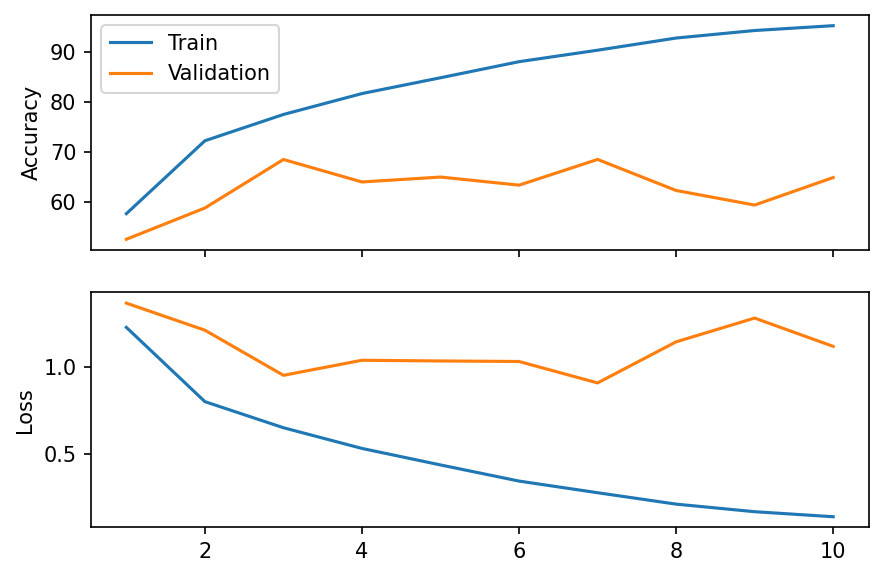

Précision en test: 64.69


In [17]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Architecture profonde

En deep learning, on dit que la performance augmente avec le nombre de couches.

### Exercice

Ajoutez 2 couches de convolution de 100 filtres dans le réseau précédent (n'oubliez pas la batch normalization et le padding). Mettez du maxpooling après la couche 1 et 3. Comparez les résultats.

In [18]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)
        
        self.conv4 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(100)
        
        self.conv5 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(100)
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.flatten(1)
        x = self.fc(x)
        return x

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|13.43s loss: 1.302418 acc: 54.045000 val_loss: 1.118512 val_acc: 61.370000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|13.68s loss: 0.833413 acc: 70.922500 val_loss: 0.790452 val_acc: 72.500000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|15.01s loss: 0.649957 acc: 77.390000 val_loss: 0.725816 val_acc: 74.910000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|14.65s loss: 0.524316 acc: 81.862500 val_loss: 0.674958 val_acc: 77.790000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|14.12s loss: 0.417965 acc: 85.500000 val_loss: 0.654059 val_acc: 77.790000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|13.72s loss: 0.329083 acc: 88.495000 val_loss: 0.698516 val_acc: 77.610000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|14.36s loss: 0.258167 acc: 90.937500 val_loss: 0.722419 val_acc: 77.530000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|14.86s loss

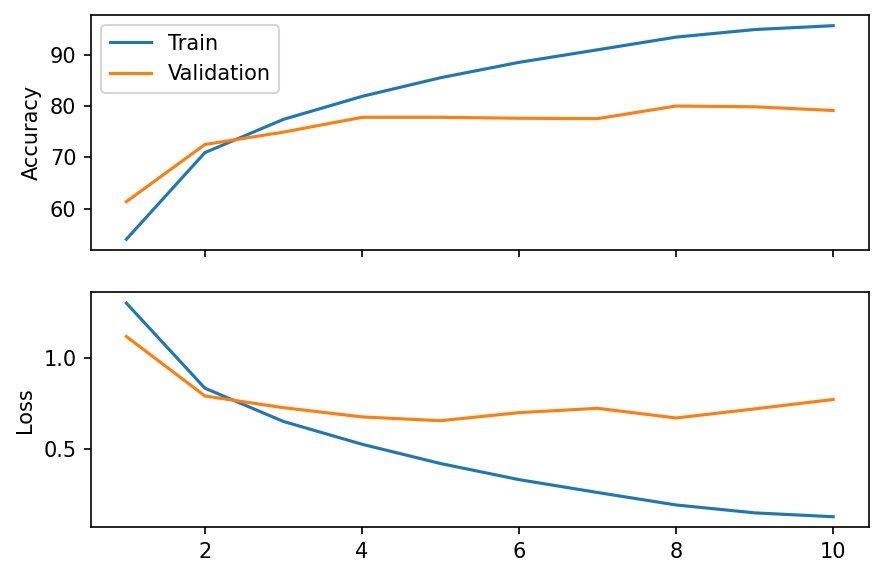

Précision en test: 78.36


In [19]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

### Exercice

Codez le réseau ci-dessous qui prend en paramètre le nombre de couches désiré. Vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) pour pouvoir avoir un nombre variable de couches. Encore une fois, chaque couche va consister en 100 filtres à convolution 3x3 avec padding de 1 suivi d'une batch normalization et d'une ReLU. Mettez du maxpooling après les couches 3 et 5. Vous pouvez supposer que le nombres de couches demandé est plus de 5. Entrainez ensuite le réseau avec 51 couches.

Est-ce que les résultats continuent à s'améliorer?

In [22]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(nn.Conv2d(100, 100, 3, padding=1))
            self.bns.append(nn.BatchNorm2d(100))
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Cette boucle parcourt les couches 2 à num_layers.
        for layer_number, conv, bn in zip(range(2, self.num_layers + 1), self.convs, self.bns):
            x = F.relu(bn(conv(x)))
            if layer_number in [3, 5]:
                x = F.max_pool2d(x, 2)
        
        x = x.flatten(1)
        x = self.fc(x)
        return x

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|65.11s loss: 2.244107 acc: 13.630000 val_loss: 2.899099 val_acc: 18.040000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|67.55s loss: 1.940560 acc: 24.000000 val_loss: 2.401315 val_acc: 19.950000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|67.74s loss: 1.761799 acc: 30.495000 val_loss: 1.885177 val_acc: 30.790000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|66.56s loss: 1.637805 acc: 37.122500 val_loss: 1.674608 val_acc: 37.240000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|66.30s loss: 1.543501 acc: 41.907500 val_loss: 1.436901 val_acc: 45.720000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|68.38s loss: 1.188536 acc: 57.062500 val_loss: 1.184454 val_acc: 58.780000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|68.37s loss: 0.990578 acc: 65.162500 val_loss: 1.212614 val_acc: 59.240000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|66.11s loss

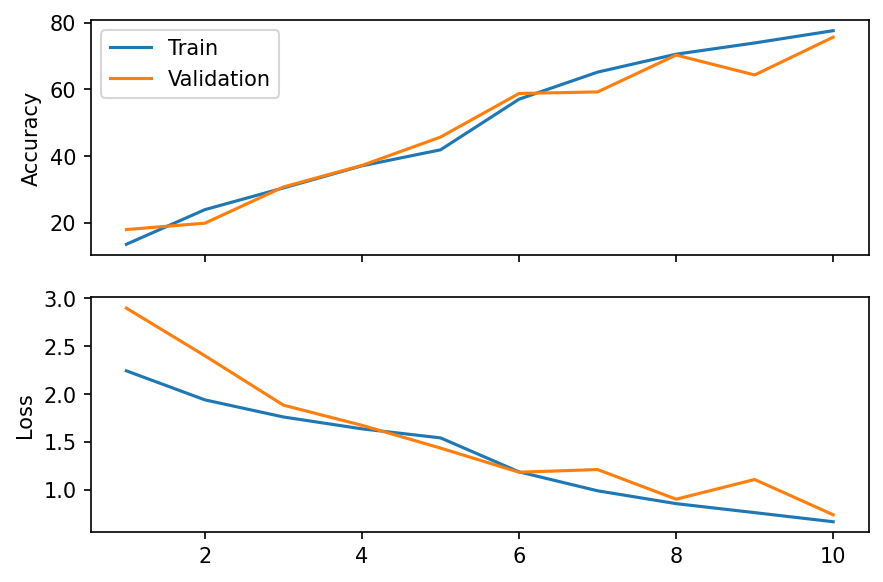

Précision en test: 75.25


In [23]:
model = ConvNet(49)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

### Un petit défi (exercice facultatif)

On vous soumet ici un défi. Le but est de réimplémenter le réseau que l'on vient de coder en utilisant le gabarit fourni ci-dessous, c'est-à-dire en utilisant seulement l'objet de type [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) dans le `forward`. Vous n'avez pas le droit de modifier la méthode `forward`, seulement la méthode `__init__`. Vous allez devoir utiliser les interfaces objets de `F.relu`, `F.max_pool2d` ainsi que de `torch.flatten`, c'est-à-dire [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU), [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) et [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten).

In [24]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        layers = []

        # TODO Ajoutez les couches à la liste "layers" ici.

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
"""

class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 2
        
        # Création de la première couche.
        layers = [
            nn.Conv2d(3, 100, 3, padding=1),
            nn.BatchNorm2d(100),
            nn.ReLU()
        ]
        
        # Cette boucle ajoute les couches 2 à num_layers.
        for layer_number in range(2, num_layers + 1):
            layers.append(nn.Conv2d(100, 100, 3, padding=1))
            layers.append(nn.BatchNorm2d(100))
            layers.append(nn.ReLU())
            if layer_number in [3, 5]: 
                layers.append(nn.MaxPool2d(2))
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(100 * 8 * 8, 10))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|72.27s loss: 2.246814 acc: 13.077500 val_loss: 2.233271 val_acc: 11.950000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|70.95s loss: 1.936296 acc: 21.425000 val_loss: 2.061354 val_acc: 18.770000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|74.62s loss: 1.888059 acc: 23.685000 val_loss: 2.118019 val_acc: 19.180000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|73.91s loss: 2.060172 acc: 18.850000 val_loss: 2.036226 val_acc: 20.540000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|69.97s loss: 1.881123 acc: 25.527500 val_loss: 1.957078 val_acc: 23.540000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|70.35s loss: 1.796436 acc: 29.217500 val_loss: 1.648966 val_acc: 35.140000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|71.89s loss: 1.726681 acc: 32.305000 val_loss: 1.655743 val_acc: 34.900000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|69.49s loss

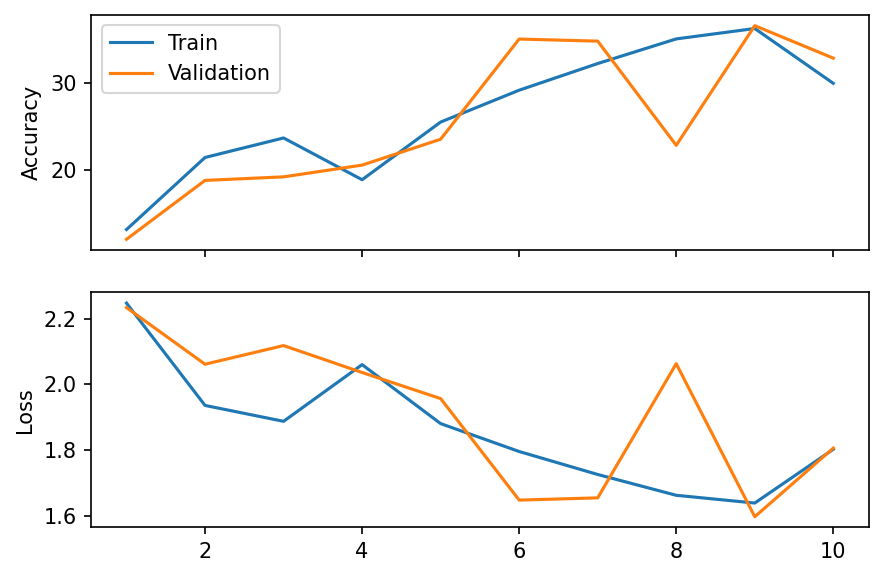

Précision en test: 33.77


In [25]:
model = ConvNet(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Connexion résiduelle

Comme vous avez pu le constater, ajouter de plus en plus de couche augmente aussi la difficulté avec laquelle le gradient peut se propager dans le réseau. Une des solutions suggérées est d'utiliser une connexion résiduelle permettant au gradient de _sauter_ des couches. Dans l'article présentant cette connexion, elle est définie comme suit:

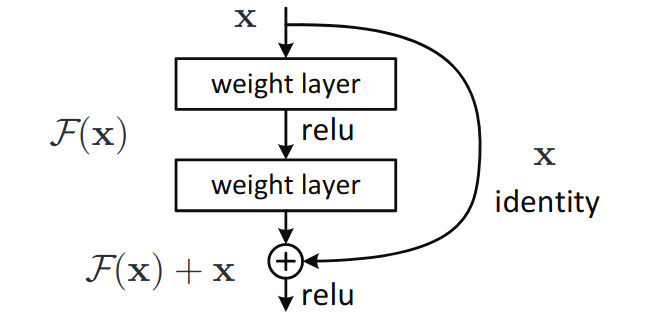

### Exercice

Implémentez cette connexion sous une forme de couche dans la classe `ResidualLayer` ci-dessous. Dans notre cas, chaque *weight layer* consiste en une couche à convolution à 100 filtres 3x3 avec padding de 1 suivi d'une batch normalization. Prenez pour acquis que le nombre de *channels* en entrée de votre couche sera de 100.

In [26]:
"""
class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self, x):
        pass
"""

class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)

        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
    
    def forward(self, x):
        res = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = F.relu(x + res)
        return x

Déboguez votre implémentation de votre couche résiduelle avec le réseau peu profond ci-dessous.

In [27]:
class ShallowResnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.res1 = ResidualLayer()
        self.res2 = ResidualLayer()
        self.res3 = ResidualLayer()

        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = F.max_pool2d(x, 2)
        x = self.res2(x)
        x = F.max_pool2d(x, 2)
        x = self.res3(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|19.49s loss: 1.666312 acc: 48.807500 val_loss: 1.146298 val_acc: 61.340000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|19.93s loss: 0.968130 acc: 66.502500 val_loss: 0.947239 val_acc: 67.900000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|19.59s loss: 0.772201 acc: 73.200000 val_loss: 0.951716 val_acc: 68.240000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|20.02s loss: 0.631529 acc: 78.040000 val_loss: 0.881074 val_acc: 71.070000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|20.21s loss: 0.518810 acc: 81.802500 val_loss: 0.847185 val_acc: 72.200000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|20.41s loss: 0.421562 acc: 85.342500 val_loss: 0.723855 val_acc: 76.010000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|20.09s loss: 0.328591 acc: 88.425000 val_loss: 0.776710 val_acc: 76.600000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|20.29s loss

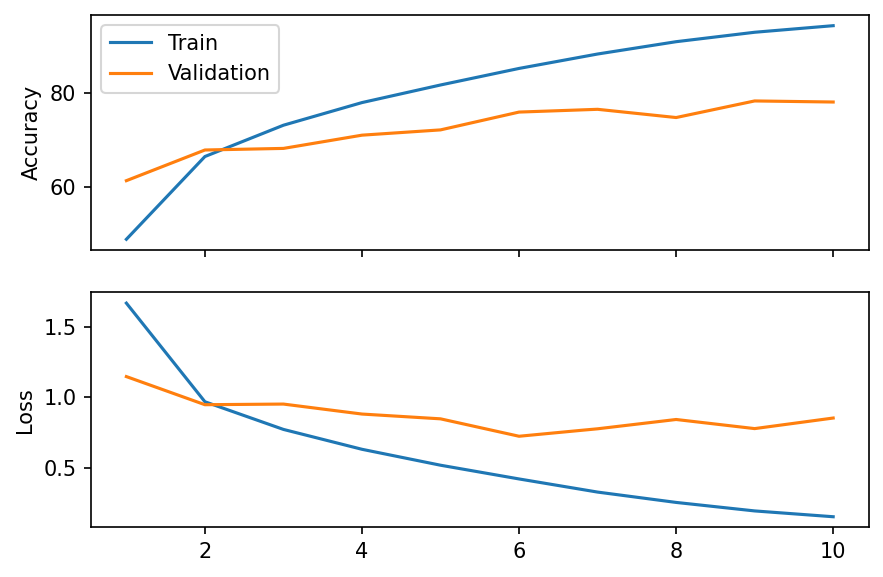

Précision en test: 78.56


In [28]:
model = ShallowResnet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

### Exercice

Codez le réseau à connexion résiduelle ci-dessous qui prend en paramètre le nombre de couches résiduelles désiré. Encore une fois, vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) ou [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) pour pouvoir avoir un nombre variable de couches. Notez qu'ici `num_layers` représente le nombre de couches résiduelles et non le nombre de couches à convolution. Le réseau devrait consister d'une couche `Conv2d -> BatchNorm2d -> ReLU` suivi de `num_layers` couches résiduelles et terminer par la couche de classification. Faites un maxpool après les couches résiduelles 1 et 2. 

Entrainez le réseau avec 25 couches résiduelles (donc au total 51 couches à convolution si compte la première couche non résiduelle). Comparez les résultats et la vitesse avec laquelle le réseau a entraîné par rapport au réseau à convolution de  51 couches entrainé plus haut.

In [29]:
"""
class Resnet(nn.Module):
    def __init__(self, num_layers):
        super(Resnet, self).__init__()
        pass

    def forward(self, x):
        pass
"""


class Resnet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 0
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.layers = nn.ModuleList([
            ResidualLayer() for _ in range(num_layers)
        ])
            
        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i <= 1:
                x = F.max_pool2d(x, 2)

        x = x.flatten(1)
        x = self.fc1(x)
        return x

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|68.47s loss: 2.027045 acc: 48.302500 val_loss: 1.183208 val_acc: 62.050000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|68.51s loss: 0.963190 acc: 67.655000 val_loss: 0.981728 val_acc: 69.090000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|68.59s loss: 0.743380 acc: 74.507500 val_loss: 0.972217 val_acc: 72.270000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|68.87s loss: 0.593178 acc: 79.605000 val_loss: 1.068402 val_acc: 73.780000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|69.60s loss: 0.474972 acc: 83.782500 val_loss: 0.728383 val_acc: 77.220000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|67.21s loss: 0.364866 acc: 87.687500 val_loss: 0.789291 val_acc: 77.450000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|67.43s loss: 0.280425 acc: 90.315000 val_loss: 1.445835 val_acc: 77.110000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|67.81s loss

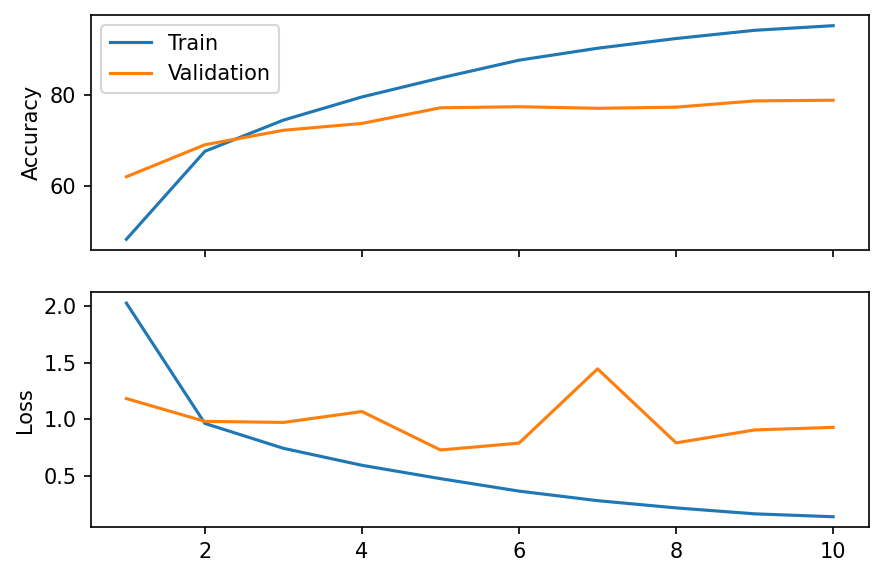

Précision en test: 78.84


In [30]:
model = Resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

### Exercice facultatif

Comme le défi lancé précédemment, tentez d'implémenter le réseau à connexion résiduelle en ne modifiant que la méthode `__init__`. Vous pouvez utiliser la couche `ResidualLayer` définie précédemment.

In [31]:
"""
class Resnet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        layers = []
        
        # TODO Ajoutez les couches à la liste "layers" ici.
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
"""

class Resnet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 2
        
        layers = [
            nn.Conv2d(3, 100, 3, padding=1),
            nn.BatchNorm2d(100),
            nn.ReLU()
        ]
        
        for i in range(num_layers):
            layers.append(ResidualLayer())
            if i <= 1:
                layers.append(nn.MaxPool2d(2))
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(100 * 8 * 8, 10))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Epoch: 1/10 Step: 1250/1250 100.00% |████████████████████|68.18s loss: 2.225416 acc: 44.757500 val_loss: 1.600535 val_acc: 58.820000
Epoch: 2/10 Step: 1250/1250 100.00% |████████████████████|68.55s loss: 1.030936 acc: 64.607500 val_loss: 1.094472 val_acc: 67.810000
Epoch: 3/10 Step: 1250/1250 100.00% |████████████████████|68.86s loss: 0.779283 acc: 72.965000 val_loss: 0.922672 val_acc: 69.080000
Epoch: 4/10 Step: 1250/1250 100.00% |████████████████████|72.09s loss: 0.624647 acc: 78.215000 val_loss: 0.728136 val_acc: 74.850000
Epoch: 5/10 Step: 1250/1250 100.00% |████████████████████|69.32s loss: 0.513130 acc: 82.302500 val_loss: 0.735781 val_acc: 76.450000
Epoch: 6/10 Step: 1250/1250 100.00% |████████████████████|70.50s loss: 0.403971 acc: 86.062500 val_loss: 3.109158 val_acc: 65.540000
Epoch: 7/10 Step: 1250/1250 100.00% |████████████████████|73.10s loss: 0.316303 acc: 89.062500 val_loss: 0.765833 val_acc: 76.540000
Epoch: 8/10 Step: 1250/1250 100.00% |████████████████████|68.16s loss

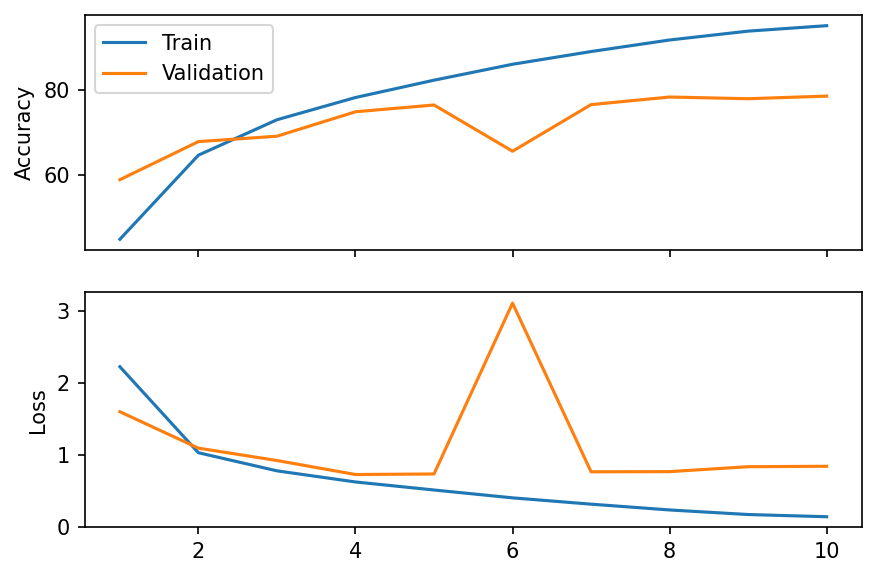

Précision en test: 78.60


In [32]:
model = Resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))